# Dynamic Programming

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('font',**{'family':'serif','sans-serif':'Helvetica','size':16})

## Q1 : MDP Model

Implementing the MDP model (see code)

In [3]:
# p(axis=0/axis=1,axis=2)
# axis=0 : state
# axis=1 : state
# axis=2 : action
MDP=np.array([[0.55,0.45,0],[0.3,0.7,0],[1,0,0],[1,0,0],[0,0.4,0.6],[0,1,0],[0,1,0],[0,0.6,0.4],[0,0,1]]).reshape(3,3,3)
MDP=np.transpose(MDP, (2,0,1))

rewards=np.array([0,0,5/100,0,0,0,0,1,9/10]).reshape(3,3)

We notice that taking action $a_2$ at state $s_2$ has the biggest reward, and always yield to stay at the state $s_2$. So the best strategy is to attain that state and loop over taking action $a_2$ to have the biggest reward. The optimal policy here is therefore simple to guess :
$$ \pi^* = [a_1, a_1, a_2]$$

## Q2 : Value iteration

The stopping criterion for the value iteration is to stop when $$ \lVert v^{k+1} - v^{k} \rVert_{\infty} < \alpha \quad \textrm{which implies} \quad \lVert v^{\pi^{k+1}} - v^{*} \rVert_{\infty} < \frac{2\alpha\gamma}{1-\gamma}$$
We want a 0.01 optimal policy, in other words we want 
$$ \lVert v^{\pi^{k+1}} - v^{*} \rVert_{\infty} < 0.01 $$
So we'll take the stoping criterion : 
$$ \alpha = \frac{0.01(1-\gamma)}{2\gamma}$$


In [4]:
class ValueIteration():
    
    def __init__(self, epsilon, gamma):
        '''
        Parameters & Attributes:
        
        epsilon: float
            convergence
        gamma: float
            Discount factor
        V_history_: np.array
            List of all value policy during iterations  
        V: np.array
            Converged value function 
        greedy_policy: np.array
            Greedy policy with regards to the converged value function
        it_: int
            Number of iterations
        '''
        self.epsilon = epsilon
        self.gamma = gamma
        self.V_history_ = None
        self.V = None
        self.greedy_policy = None
        self.it_ = None
        
    def Bellman_operator(self, V, MDP, rewards, gamma):
        """
        Bellman Operator for a given MDP, discount factor and rewards
        """
        return np.max(rewards + gamma * np.einsum('kij, k -> ij',MDP,V),axis=1)
    
    def value_function_from_policy(self, MDP, rewards, policy):
        """
        Compute value function from policy given MDP and rewards
        """
        P=self.gamma*(MDP[:,[0,1,2],policy].T)
        R=rewards[[0,1,2],policy]      
        return np.matmul(np.linalg.inv(np.eye(MDP.shape[0])-P),R)
    
    def compute_greedy_policy(self, rewards, MDP, value_function):
        """
        Compute greedy policy from a value function
        """
        return np.argmax(rewards + self.gamma * np.einsum('kij, k -> ij',MDP,value_function),axis=1)
        
    def run(self, MDP, rewards):
        """ Run value iteration algorithm
        
        Parameters:
        -----------
        MDP : np.array
            The first axis is the new state, second axis is the current state and third axis is the action taken
        rewards: np.array
            The first axis is the state and the second axis is the action taken
        
        Returns:
        -----
        (V, Policy) : 
        """     
        
        self.MDP = MDP
        self.r = rewards
        self.V_history_ = [np.random.uniform(0,1,self.MDP.shape[0])]
        
        criterion = (1-self.gamma)*self.epsilon/(2*self.gamma)
        
        converged=False
        self.it_=0
        
        while (not converged):
            self.it_+=1
            V=self.Bellman_operator(self.V_history_[-1], MDP, self.r, self.gamma)
            if np.max(np.abs(V-self.V_history_[-1]))<criterion:
                converged=True
            self.V_history_+=[V]
        
        self.V = V
        self.greedy_policy = self.compute_greedy_policy(self.r, self.MDP, self.V)        
        return self.greedy_policy 
    
    def plot_evolution(self,optimal_value_function):
        """
        Plot the inifinity norm of the difference of the optimal function
        and the value functions computed along iterations
        """
        plt.plot(np.max((np.abs(np.array(VI.V_history_) - optimal_value_function)),axis=1))
        plt.xlabel("Iterations : k")
        plt.ylabel('$||v_k - v^*||_\infty$')
        plt.show()

Running Value Iteration :

In [5]:
VI = ValueIteration(epsilon=1e-2,gamma=0.95)
Greedy_Policy = VI.run(MDP,rewards)
print("Number of iterations :",VI.it_)
print("Greedy Policy found :",Greedy_Policy)

Number of iterations : 159
Greedy Policy found : [1 1 2]


Compute the optimal policy using the greedy policy :

In [6]:
V_star = VI.value_function_from_policy(MDP, rewards, Greedy_Policy)
print("V* :",V_star)

V* : [15.39115723 16.5483871  18.        ]


Plotting the inifinity norm evolution along iterations

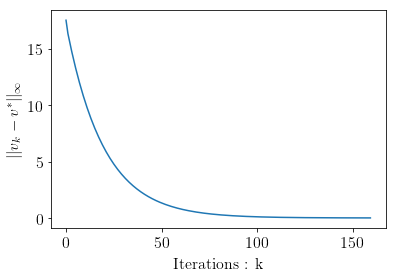

In [7]:
VI.plot_evolution(V_star)

## Q3 : Policy iteration

In [8]:
class PolicyIteration():
    
    def __init__(self, gamma):
        '''
        Parameters & Attributes:
        
        gamma: float
            Discount factor
        policy_history_: np.array
            List of all policies during iterations  
        V: np.array
            Converged value function 
        greedy_policy: np.array
            Greedy policy with regards to the converged value function
        it_: float
            number of iterations
        '''
        self.gamma = gamma
        self.policy_history_ = None
        self.V = None
        self.greedy_policy = None
        self.it_ = None
        
    def Bellman_operator(self, V, MDP, rewards, gamma):
        """
        Bellman Operator for a given MDP, discount factor and rewards
        """
        return np.max(rewards + gamma * np.einsum('kij, k -> ij',MDP,V),axis=1)
    
    def compute_greedy_policy(self, V, MDP, rewards, gamma):
        """
        Compute greedy policy from a value function
        """
        return np.argmax(rewards + gamma * np.einsum('kij, k -> ij',MDP,V),axis=1)
    
    def value_function_from_policy(self, MDP, rewards, policy):
        """
        Compute value function from policy given MDP and rewards
        """
        P=self.gamma*(MDP[:,[0,1,2],policy].T)
        R=rewards[[0,1,2],policy]
        return np.linalg.solve(np.eye(MDP.shape[0])-P,R)
        
    def run(self, MDP, rewards):
        """ Run policy iteration algorithm
        
        Parameters:
        -----------
        MDP : np.array
            The first axis is the new state, second axis is the current state and third axis is the action taken
        rewards: np.array
            The first axis is the state and the second axis is the action taken
        
        Returns:
        -----
        (V, Policy) : 
        """     
        
        self.MDP = MDP
        self.r = rewards
        self.policy_history_ = [np.zeros(MDP.shape[2],dtype='int')]
        self.V=self.value_function_from_policy(MDP, rewards, self.policy_history_[-1]) 
        
        converged=False
        self.it_=0
        
        while (not converged):
            self.it_+=1
            self.greedy_policy = self.compute_greedy_policy(self.V, MDP, self.r, self.gamma)
            if np.all(self.greedy_policy==self.policy_history_[-1]):
                converged=True
            self.policy_history_+=[self.greedy_policy]
            self.V = self.value_function_from_policy(MDP, rewards, self.greedy_policy)       
        
        return self.greedy_policy
        
    def plot_evolution(self,value_function_compare):
        plt.plot(np.max((np.abs(np.array(VI.V_history_) - value_function_compare)),axis=1))
        plt.show()

Running Policy Iteration :

In [9]:
PI = PolicyIteration(gamma=0.95)
Greedy_Policy = PI.run(MDP,rewards)
print("Number of iterations :",PI.it_)
print("Greedy Policy found :",Greedy_Policy)

Number of iterations : 4
Greedy Policy found : [1 1 2]


## Comparison between VI and PI

In [10]:
VI = ValueIteration(epsilon=1e-2,gamma=0.95)
print("Value iteration algorithm time execution on average :")
%timeit Greedy_Policy = VI.run(MDP,rewards)

Value iteration algorithm time execution on average :
2.45 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
PI = PolicyIteration(gamma=0.95)
print("Policy iteration algorithm time execution on average :")
%timeit Greedy_Policy = PI.run(MDP,rewards)

Policy iteration algorithm time execution on average :
188 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We notice that the **value iteration algorithm** converges to the optimal policy in **2.32ms for a total of 160 iterations.**

The **policy iteration algorithm** converges to the same optimal policy in **187$\mu s$ for a total of 4 iterations.**

The policy iteration algorithm is much faster than the value iteration algorithm, despite the fact that its time complexity is much greater than the VI time complexity. In fact, since the MDP has a small number of possible actions, it admits a small finite number of policies which explains that PI is faster than VI despite the gap in computation complexity.

# Reinforcement Learning

In [12]:
from gridworld import GridWorld1
import gridrender as gui
import numpy as np

In [13]:
env = GridWorld1

## Q4 : Monte-Carlo Estimator

In [14]:
# Here the v-function and q-function to be used for question 4
v_q4 = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514]

### Setting Parameters :

We'll choose the discount factor $\gamma = 0.95$, and $T_{max}$ the length of one episode as : 
$$T_{max}=-\frac{log(\delta/R_{max})}{1-\gamma} $$
with $R_{max} = 1$ the maximum reward, and $\delta=1e-3$.

We then have $T_{max}\approx 139$

In [15]:
gamma=0.95
Rmax = 1
delta=1e-3
Tmax = int(np.ceil(-np.log(delta/Rmax)/(1-gamma)))

### Building the policy :

The policy to consider here is to take right if available and up otherwise :

In [16]:
policy=[]
for actions in env.state_actions:
    if 0 in actions:
        policy+=[0]
    else: policy+=[3]
        
#gui.render_policy(env, policy)

### Estimating the initial state distribution :

Running 100000 resets to estimate the distribution :

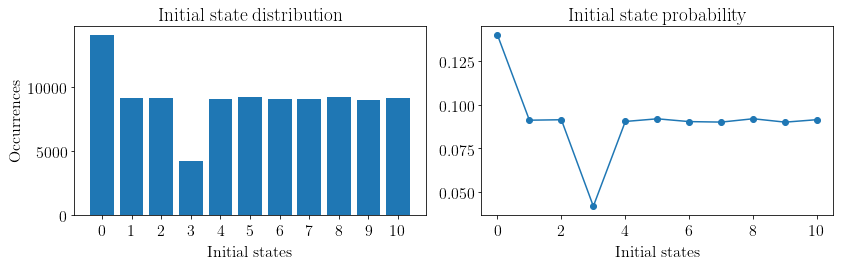

In [17]:
Initial_states=[]
for i in range(100000):
    Initial_states+=[env.reset()]
Initial_states=np.array(Initial_states)
labels, counts = np.unique(Initial_states, return_counts=True)
mu0 = counts/100000

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.bar(labels, counts, align='center')
ax1.set_xticks(labels)
ax1.set_xlabel("Initial states")
ax1.set_ylabel("Occurrences")
ax1.set_title("Initial state distribution")


ax2.plot(mu0,"-o")
ax2.set_xlabel("Initial states")
ax2.set_title("Initial state probability")

plt.tight_layout()
plt.show()

### Monte Carlo Estimator :

In [18]:
class MonteCarlo():
    """
    Compute the Monte-Carlo estimator of the value function
    for episodes of length Tmax.
    """
    def __init__(self, n, Tmax, gamma, policy, env):
        '''
        Parameters & Attributes:
        
        n: int
            Total number of trajectories
        Tmax: int
            Lenght of one episode  
        gamma: float
            Discount factor 
        policy: np.array
            the policy chosen
        env:
            The MDP simulator
            
        counts_: np.array
            Stores how often a state has been visited
        V_ns_: np.array
            Contains the montecarlo value functions estimators along trajectories
        
        '''
        self.n = n
        self.Tmax = Tmax
        self.gamma = gamma
        self.policy = policy
        self.env = env
        
        self.counts_ = None
        self.V_ns_ = None

    def run(self):
        """       
        Running the MonteCarlo algorithm
        """
        self.counts_ = np.zeros(self.env.n_states)
        gammas = np.array([gamma**k for k in range(self.Tmax)])
        self.V_ns_ = np.zeros((self.n,self.env.n_states))

        # Running n trajectories
        for i in range(self.n):       
            state = self.env.reset()
            init_state=state
            self.counts_[init_state]+=1

            rewards=np.zeros(self.Tmax,dtype=int)
            alpha=1/(self.counts_[init_state])

            for t in range(self.Tmax):
                action = self.policy[state]
                nexts, rewards[t], term = env.step(state,action)
                state = nexts

            self.V_ns_[i,:]=self.V_ns_[i-1,:]
            self.V_ns_[i,init_state]=(1-alpha)*self.V_ns_[i,init_state] + alpha*np.dot(rewards,gammas)

        return self.V_ns_
    
    def compute_J_n(self,V_n,mu0):
        """
        Compute J_n

        Parameters:

        V_n: np.array
            Value function
        mu0: np.array
            Inital states distribution

        """
        return np.dot(V_n,mu0)
        
    def plot_evolution(self,J_n_values,J_pi):
        """        
        Plot J_n - J_pi along trajectories
        
        Parameters:
        
        J_n_values: np.array
            J_n values along trajectories
        J_pi: float
            J value the value function of the policy chosen for the algorithm
        """        
        plt.figure(figsize=(12,4))
        plt.plot(J_n_values-J_pi)
        plt.ylabel("$J_n - J^\pi$")
        plt.xlabel("n")
        plt.show()

Running the Monte Carlo algorithm for 1000 trajectories :

In [19]:
MC_estimator=MonteCarlo(n=1000, Tmax=Tmax, gamma=0.95, policy=policy, env=env)
Vn_s = MC_estimator.run()

Computing $J_n$ for every $V_{n}$ for n in $\{1,2, ..., 1000\}$ :

In [20]:
J_n_values = MC_estimator.compute_J_n(Vn_s,mu0)

Computing $J^\pi$ :

In [21]:
J_pi = MC_estimator.compute_J_n(v_q4,mu0)

Ploting $J_n - J^\pi$ for n in $\{1,2, ..., 1000\}$ :

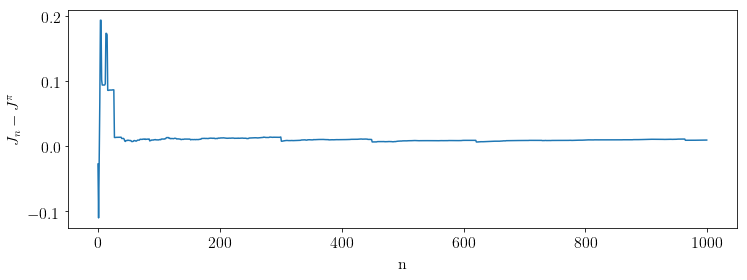

In [22]:
MC_estimator.plot_evolution(J_n_values,J_pi)

## Q5 : Q-Learning

In [23]:
#Here is the optimal policy :
v_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001]

### Describing the Q-Learning algorithm parameters

We'll choose a learning rate defined as follows :
$$ \alpha_i(x_t,a_t) = \frac{1}{\textrm{#visits}(x_t,a_t)}$$

The policy exploration is chosen as follows :

For a state $x_t$, we'll define the following actions :
- **Action 1** : $a_t$ = $argmax_a Q(x_t, a)$ with $a\in\mathcal{A}(x_t)$ (possible actions at state $x_t$)
- **Action 2** : $a_t$ = Random action from $\mathcal{A}(x_t)$

The policy will take the action 1 with a probability $1-\epsilon$, and action 2 with a probability $\epsilon$. Therefore :
$$\pi(x_t) = \theta*action_1 + (1-\theta)*action_2$$
$$\textrm{with} \quad \theta \sim \mathcal{B}(1-\epsilon)$$

We will choose **epsilon = 0.4**

These parameters satisfy the **Robbins-Monro conditions**.

### Q-Learning Algorithm

In [24]:
class QLearning():
    
    def __init__(self, n, Tmax, gamma, epsilon, env):
        '''
        Parameters & Attributes:
        
        n: int
            Total number of trajectories
        Tmax: int
            Lenght of one episode  
        gamma: float
            Discount factor 
        epsilon: float
            Parameter for the greedy exploration policy
        env:
            The MDP simulator
        
        Q_: np.array
            Q(x,a) matrix
        V_s_: np.array
            Contains the greedy value functions wtr Q along trajectories
        counts_: np.array
            Stores how often a state s with an action a has been visited
        cumulative_rewards_: np.array
            Stores the cumulative reward along trajectories
        '''
        self.n = n
        self.Tmax = Tmax
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env
        
        self.Q_ = None
        self.Vs_ = None
        self.counts_ = None
        self.cumulative_rewards_ = None
    
    def greedy_exploration_policy(self, state):
        """
        Define the epsilon-greedy exploration policy
        
        Parameters:
        
        state: int
            current state
        """
        action1 = self.env.state_actions[state][np.argmax(self.Q_[state,self.env.state_actions[state]])]
        action2 = np.random.choice(self.env.state_actions[state])
        theta = np.random.binomial(1,1-self.epsilon)       
        return theta*action1 + (1-theta)*action2
    
    
    def run(self):
        """
        Running the Q-Learning algorithm
        """
        self.counts_ = np.zeros((self.env.n_states,len(self.env.action_names)), dtype=int)
        self.Q_ = np.zeros((self.env.n_states,len(self.env.action_names)))
        self.Vs_ = np.zeros((self.n,self.env.n_states))
        self.cumulative_rewards_ = np.zeros(self.n)
        rewards = np.zeros((self.n,self.Tmax), dtype=int)
        gammas = np.array([self.gamma**k for k in range(self.Tmax)])
        
        # Running n trajectories
        for i in range(self.n):       
            state = self.env.reset()

            # Running (i+1)-th trajectory
            for t in range(self.Tmax):
                action = self.greedy_exploration_policy(state)
                self.counts_[state,action]+=1        
                alpha=1/(self.counts_[state,action])

                nexts, rewards[i,t], term = self.env.step(state,action)
                delta = rewards[i,t] + self.gamma*np.max(self.Q_[nexts,:]) - self.Q_[state,action]
                #Update
                self.Q_[state,action] = self.Q_[state,action] + alpha*delta
                state = nexts   
            
            # Computing value function wrt Q for the (i+1)-th trajectory
            self.Vs_[i,:] = np.max(self.Q_,axis=1)
            
            # Computing the accumulated rewards for the (i+1)-th trajectory
            self.cumulative_rewards_[i] = self.cumulative_rewards_[i-1] + np.dot(rewards[i,:],gammas)
            
        return self.Q_
        
    def plot_evolution(self,optimal_val_func):
        """        
        Plot the infinity norm evolution of the difference between
        the optimal value function and the value function wrt Q
        computed along trajectories. Also plots the cumulative rewards
        along trajectories.
        
        Parameters:
        
        optimal_val_func: np.array
            Optimal value function
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
        ax1.plot(np.max((np.abs(self.Vs_ - optimal_val_func)),axis=1))
        ax1.set_ylabel("$||v^* - v^{\pi_n}||_\infty$")
        ax1.set_xlabel("$Trajectories : n$")
        ax1.set_title("Performance over all the other state")
        
        ax2.plot(self.cumulative_rewards_)
        ax2.set_ylabel("$$\sum_{k=1}^{n}\sum_{t=1}^{T_{max}}\gamma^{t-1}r_t^(k)$$")
        ax2.set_xlabel("$Trajectories : n$")
        ax2.set_title("Reward cumulated over the episodes")
        
        plt.tight_layout()
        plt.show()

Running the algorithm for 5000 trajectories :

In [25]:
Q_Learner = QLearning(n=5000, Tmax=Tmax, gamma=gamma, epsilon=0.4, env=env)
Q_star = Q_Learner.run()

In [26]:
Policy_star = np.argmax(Q_star,axis=1)
#gui.render_policy(env,Policy_star)

Computing the optimal policy found by the Q-Learning :

In [27]:
V_star = np.max(Q_star,axis=1)
print("Q-Learning Optimal Policy :")
print(list(V_star))
print("---")
print("Real Optimal Policy :")
print(v_opt)

Q-Learning Optimal Policy :
[0.8459027937777587, 0.9145743616191396, 0.9840041955462653, 0.0, 0.7509856987457841, 0.9167984650015677, 0.0, 0.6565954615884034, 0.7615621148159111, 0.8524442901747938, 0.7614512120900885]
---
Real Optimal Policy :
[0.87691855, 0.92820033, 0.98817903, 0.0, 0.82369294, 0.92820033, 0.0, 0.77818504, 0.82369294, 0.87691855, 0.82847001]


We notice that the optimal policy found is near to the true optimal policy.

Plotting the evolution :

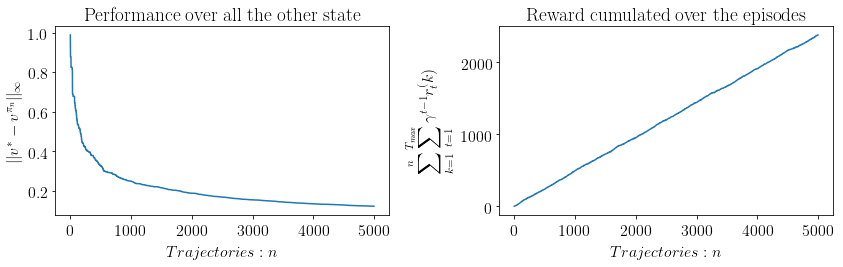

In [28]:
Q_Learner.plot_evolution(v_opt)

## Q6 : Initial state distribution effect

Yes, the optimal policy found by the algorithm **is affected by the initial state distribution**. 

The Robbins-Monro conditions impose that all states have to be visited **infinitely often** in order to converge towards the optimal Q and therefore the optimal value function. The **exploration** of states in then **crucial**

- If the MDP doesn't explore well all the states, the algorithm will converge to the optimal policy only if the initial state distribution is large in order to start from all the states. 
- On the other hand, if the MDP explores well all the states, if we take an initial distribution that only starts from an absorbing state for example, the algorithm won't converge to the optimal policy.